In [2]:
import os         # importing all requried liberaries
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
import pickle
import datetime
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
dirac = r'D:\ML\Analysis of Amazon Cell Phone Reviews\data'   # my local directory where data is stored

In [ ]:
files = os.listdir(dirac)    #listing all files in dirac path 
files

In [ ]:
for file in files:             # joining file name from files list to the path in dirac
    path = os.path.join(dirac,file)
    print(path)

In [ ]:
items = pd.read_csv(r'D:\ML\Analysis of Amazon Cell Phone Reviews\data\20191226-items.csv') 

In [ ]:
reviews = pd.read_csv(r'D:\ML\Analysis of Amazon Cell Phone Reviews\data\20191226-reviews.csv')

In [ ]:
items.head(10)

In [ ]:
reviews.head()

In [ ]:
final_data = pd.merge(reviews, items, how="left", left_on="asin", right_on="asin") 
date = pd.to_datetime(final_data['date']) # converting date time to pandas datetime type
final_data.date = date
"""merging both data along asin column
   doing lest join insted of right because i want every row in reviews to be present in final data
   i case of right join if there is areview missing for a asin it will be replaced by NAN
   this data is only for visualisation 
"""

In [ ]:
reviews['sentiment'] = reviews.rating.apply(lambda x : 1 if x>=3 else 0) # lets create a sentiment column wit an asumption that rating greater than 3 is a positive sentiment 
reviews['review'] = reviews.title+reviews.body # adding both title and review columns

In [ ]:
data = reviews[['review','sentiment']] #this is our final data with all columns we need

In [ ]:
data.isna().sum()

In [ ]:
data = data.dropna()

In [ ]:
data.isna().sum()

In [ ]:
data.review.shape

#  Data Visualisation

## Pie chart to see brand distribution along our dataset

In [ ]:
brand_size = items.groupby('brand').count()['asin']
labels = list(brand_size.index)
plt.figure(figsize=(15,10))
plt.rcParams['text.color'] = 'w'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size']  = 20
plt.title('Total number of products per brands')
plt.pie(brand_size,labels=labels,autopct='%1.1f%%')
plt.show()

### Lets group our reviews by brand see what is mean rating for a given brand

In [ ]:
ratings = items.groupby('brand').mean()['rating'].sort_values()
label = list(ratings.index)
plt.figure(figsize=(15,8))
plt.rcParams['text.color'] = 'w'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size']  = 20
plt.title('Mean review points per brand')
plt.barh(label,ratings,height=0.5)
plt.show()

### Lets plot a bar chart to understand our data and see wether we have enough data for each rating values

<style>
td {
  font-size: 100px
    Lets plot a bar chart to understand our data and see wether we have enough data for each rating values
}
</style>


In [ ]:
rating_group = reviews.groupby('rating').count()
plt.figure(figsize=(15,8))
plt.xlabel('ratings')
plt.ylabel('Number of instances')
plt.bar(rating_group.index,rating_group.asin,width=0.5)

### PLoting the number of reviews activity

In [ ]:
activity = final_data.groupby('date').count()['asin']
dates = activity.index
plt.figure(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('number of reviews')
plt.title('Date vs Number of reviews')
plt.bar(dates,activity,width=0.2,align='center',color='r')

### We want out data to have same amount of positive and negitive sentiment otherwise our model will be bias so lets see percentage of positve and negitive sentiment in our data 

In [ ]:
#example if your model have 75% positive data and 25% negitive data then our model will figur out if it predicts potive everytime it will be right 3 times for every 4 instances an dit will be very dificult
#for our model to learn and genralise the data

In [ ]:
sent_count = data.groupby('sentiment').count()
neg_per = sent_count.review[0]*100/sent_count.review.sum()
pos_per = sent_count.review[1]*100/sent_count.review.sum()
plt.figure(figsize=(10,8))
plt.annotate(neg_per,(0,30))
plt.bar(['negitive','postive'],[neg_per,pos_per],width=0.2)

In [ ]:
# as we can see there is huge diffrence in positive and negitive sentiment this will lead to many false positive results 
#possible solutions 1) droping some postive values 2)collect more data

In [ ]:
pos = data.loc[data.sentiment==1]
neg= data.loc[data.sentiment==0]

In [ ]:
pos.shape,neg.shape

In [ ]:
df = pd.concat([pos[:16000],neg[:16000]]) #lets only take 16k instance of both positive and negitive label

In [ ]:
df

## Features and target genration and text cleaning

In [ ]:
def data_genrator(df):
    ps = PorterStemmer()
    y = df.sentiment #target   
    words = []
    for i in range (0,len(df)):
        X = df.review.iloc[i]
        X = re.sub('[^a-zA-Z]',' ',X)
        X = X.lower()
        X = X.split()
        X = [ps.stem(w) for w in X if not w in stopwords.words('english')]
        X = ' '.join(X)
        words.append(X)
    return words,y

In [ ]:
X,y = data_genrator(df)

In [ ]:
vect = CountVectorizer(max_features=5000,max_df=0.75)#max_df=0.7 will skip featuers that are repeated in 75% of the instances 
#choosing only 5000 featuers because data has around 30k featuers this will lead to curse of dimensionality

In [ ]:
X = vect.fit_transform(X).toarray()

In [ ]:
X.shape

In [ ]:
y = np.array(y)
X = np.array(X)

In [ ]:
X

## train and test datasets creation

In [ ]:
# i am choosing only 32000 instances from the data and creating train set, dev set and test set
# it is important to make sure thatr every set have equal number of both positive reviews mand negitive reviews to make sure that our model is not bias

In [ ]:
train_size_index = 12000
dev_size_index = 14000 
test_size_index = 16000
X_pos,X_neg = X[:16000],X[16000:]
y_pos,y_neg = y[:16000],y[16000:]
X_train = np.concatenate((X_pos[:train_size_index],X_neg[:train_size_index]))
X_dev = np.concatenate((X_pos[train_size_index:dev_size_index],X_neg[train_size_index:dev_size_index]))
X_test = np.concatenate((X_pos[dev_size_index:],X_neg[dev_size_index:]))

y_train = np.concatenate((y_pos[:train_size_index],y_neg[:train_size_index]))
y_dev = np.concatenate((y_pos[train_size_index:dev_size_index],y_neg[train_size_index:dev_size_index]))
y_test = np.concatenate((y_pos[dev_size_index:],y_neg[dev_size_index:]))

In [ ]:
X_train.shape,X_dev.shape,X_test.shape

In [ ]:
train_data = list(zip(X_train,y_train))
random.shuffle(train_data)
X_train,y_train = zip(*train_data)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
dev_data = list(zip(X_dev,y_dev))
random.shuffle(test_data)
X_dev,y_dev = zip(*dev_data)
X_dev = np.array(X_dev)
y_dev = np.array(y_dev)

In [ ]:
test_data = list(zip(X_test,y_test))
random.shuffle(test_data)
X_test,y_test = zip(*test_data)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
with open('X_train.pickle', 'wb') as f:
    pickle.dump(X_train, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('X_dev.pickle', 'wb') as f:
    pickle.dump(X_dev, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_dev.pickle', 'wb') as f:
    pickle.dump(y_dev, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('X_test.pickle', 'wb') as f:
    pickle.dump(X_test, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
X_train = pickle.load(open('X_train.pickle','rb'))
y_train = pickle.load(open('y_train.pickle','rb'))
X_dev = pickle.load(open('X_dev.pickle','rb'))
y_dev = pickle.load(open('y_dev.pickle','rb'))
X_test = pickle.load(open('X_test.pickle','rb'))
y_test = pickle.load(open('y_test.pickle','rb'))

In [41]:
model = Sequential()

In [42]:
model.add(Dense(5000,activation='relu'))

In [43]:
model.add(Dropout(0.25))

In [44]:
model.add(Dense(128,activation='relu'))

In [45]:
model.add(Dense(1,activation='sigmoid'))

In [46]:
adm = tf.keras.optimizers.Adam(lr=1e-6,decay=1e-6) #defining learning rate and decay for better control

In [47]:
model.compile(loss = 'binary_crossentropy',metrics = ['accuracy'],optimizer = adm)

In [48]:
%load_ext tensorboard
logdir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
#callback for tensorbord

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [49]:
loss_moniter = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto',baseline=None, restore_best_weights=False)
#this callback will moniter the validation loss and stops the epoch when there is no improvement greter than min_delta for patiience number of epoch

In [ ]:
history = model.fit(X_train,y_train,epochs=200,batch_size=64,validation_data=(X_dev,y_dev),callbacks=[loss_moniter])

Train on 24000 samples, validate on 4000 samples
Epoch 1/200
24000/24000 [==============================] - 7s 301us/sample - loss: 0.6871 - accuracy: 0.5681 - val_loss: 0.6773 - val_accuracy: 0.7015
Epoch 2/200
24000/24000 [==============================] - 7s 282us/sample - loss: 0.6681 - accuracy: 0.7301 - val_loss: 0.6609 - val_accuracy: 0.7903
Epoch 3/200
24000/24000 [==============================] - 7s 284us/sample - loss: 0.6483 - accuracy: 0.8004 - val_loss: 0.6422 - val_accuracy: 0.8195
Epoch 4/200
24000/24000 [==============================] - 7s 284us/sample - loss: 0.6269 - accuracy: 0.8292 - val_loss: 0.6225 - val_accuracy: 0.8375
Epoch 5/200
24000/24000 [==============================] - 7s 283us/sample - loss: 0.6042 - accuracy: 0.8488 - val_loss: 0.6025 - val_accuracy: 0.8505
Epoch 6/200
24000/24000 [==============================] - 7s 283us/sample - loss: 0.5816 - accuracy: 0.8616 - val_loss: 0.5818 - val_accuracy: 0.8590
Epoch 7/200
24000/24000 [====================

In [ ]:
model.save('model.h5')

In [5]:
model = tf.keras.models.load_model('model.h5')

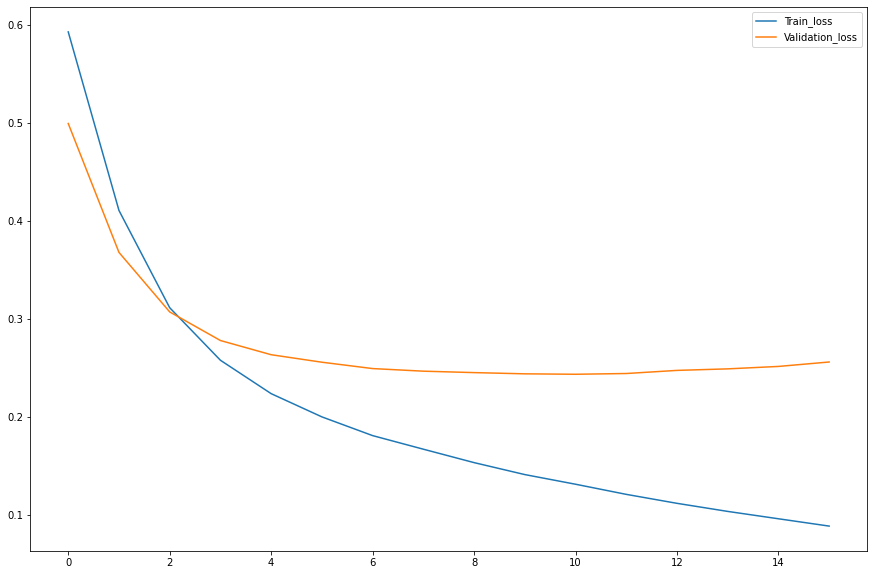

In [31]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train_loss','Validation_loss'])
plt.rcParams['text.color'] = 'b'

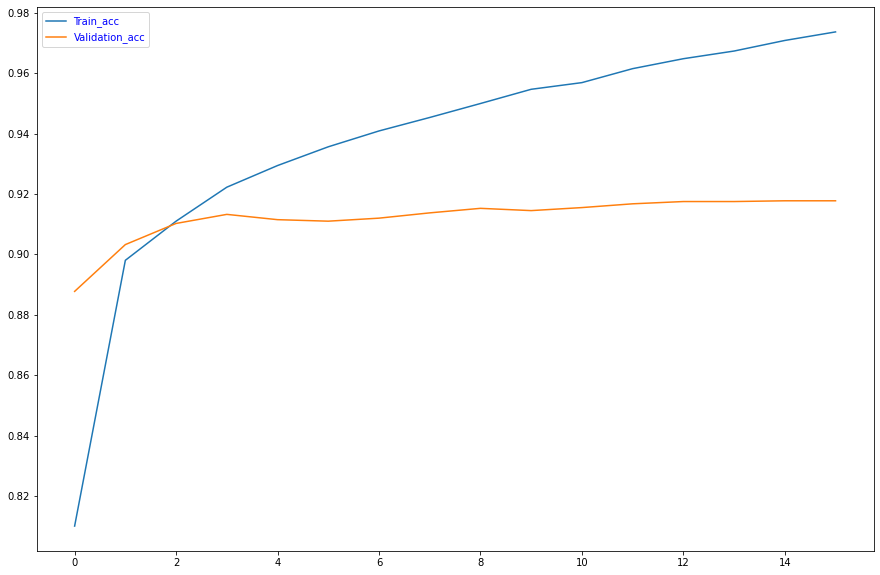

In [32]:
plt.figure(figsize=(15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train_acc','Validation_acc'])
plt.rcParams['text.color'] = 'b'

In [33]:
y_pred = model.predict_classes(X_test)

In [34]:
cm = confusion_matrix(y_test,y_pred)

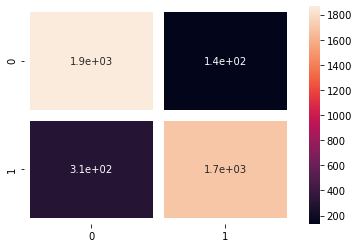

In [35]:
sns.heatmap(cm,annot=True,linewidths=10)

In [36]:
fpr,tpr,treshhold = roc_curve(y_test,y_pred)

In [37]:
area = auc(fpr,tpr)

Text(0, 1, 'area under curve is 0.8895')

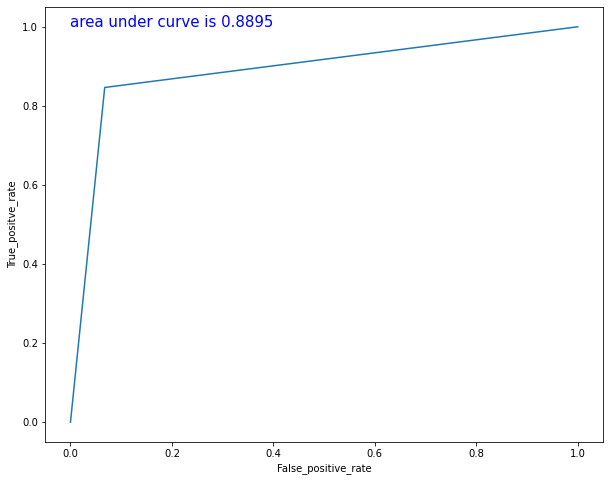

In [38]:
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr)
plt.xlabel('False_positive_rate')
plt.ylabel('True_positve_rate')
plt.rcParams['font.size'] = 15
plt.annotate('area under curve is %s'%round(area,4),(0,1))